# Figure 5

In Figure 5, we present enrichment of TF motifs near differentially expressed genes for the TFs that are, themselves, most strongly differentially expressed in Lenalidomide and Bortezomib treatments.

The pivotal factor for these comparisons is IKZF1, which is strongly differentially expressed under both Lenalidomide and Bortezomib treatment, but in opposite directions.

To provide some context for IKZF1 results, we'll present motif enrichment for the top 5 differentially expressed TF genes in both directions for both drugs.

Paired heatmap plots will show both the differentialy expression of each TF, as well as enrichment of each top TF's motifs near significantly differentially-expressed genes in each direction. See the notebook at `04-atac-analysis/03-R_deg_motif_enrichment.ipynb` for further details.

## Load packages

hise: The Human Immune System Explorer R SDK package  
purrr: Functional programming tools  
dplyr: Dataframe handling functions  
ggplot2: plotting functions  
cowplot: multi-panel plot assembly  

In [1]:
quiet_library <- function(...) { suppressPackageStartupMessages(library(...)) }
quiet_library(hise)
quiet_library(purrr)
quiet_library(dplyr)
quiet_library(ggplot2)
quiet_library(cowplot)

In [2]:
out_dir <- "output/figure_5"
if(!dir.exists(out_dir)) { dir.create(out_dir) }

## Retrieve files

Now, we'll use the HISE SDK package to retrieve the analysis results for DEG, Hallmark Pathway enrichment, and motif enrichment.

In [3]:
deg_uuid <- list("fc83b89f-fd26-43b8-ac91-29c539703a45")

In [4]:
deg_fres <- cacheFiles(deg_uuid)
deg_file <- list.files(
    paste0("cache/",deg_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



In [5]:
tf_uuid <- list("06039bda-26a0-4a51-85b4-f2b5aedcdf74")

In [6]:
tf_fres <- cacheFiles(tf_uuid)
tf_file <- list.files(
    paste0("cache/",tf_uuid),
    recursive = TRUE, full.names = TRUE
)

submitting request as query ID first...

retrieving files using fileIDS...



## Prepare data

In [7]:
tf_fdr_cutoff <- 0.01
top_n_tf <- 5
enrichment_fdr_cutoff <- 0.05

In [8]:
type_colors <- read.csv("../common/color_sets/aifi_cell_type_colors.csv")

In [9]:
res <- read.csv(tf_file)

In [10]:
res <- res %>%
  filter(direction != "all") %>%
  mutate(frac_deg = n_ol / n_deg)

In [11]:
names(res)

[1] "treatment"      "timepoint"      "aifi_cell_type" "direction"     
 [5] "motif_id"       "tf_gene"        "tf_logFC"       "tf_adjP"       
 [9] "n_all_genes"    "n_motif_genes"  "n_deg"          "n_ol"          
[13] "nomP"           "ol_genes"       "adjP"           "frac_deg"

## Lenalidomide results

In [12]:
treat <- "lenalidomide"

keep_tf <- res %>%
  select(treatment, timepoint, aifi_cell_type, tf_gene, tf_logFC, tf_adjP) %>%
  unique() %>%
  filter(treatment == treat,
         tf_adjP < tf_fdr_cutoff)

tt_res <- res %>%
  filter(treatment == treat,
         tf_gene %in% keep_tf$tf_gene)

Score TFs based on sum(target logFC) * fraction of DEGs? Or mean(target logFC)?

In [13]:
tf_pos <- keep_tf %>%
  group_by(tf_gene) %>%
  summarise(mean_logFC = mean(tf_logFC, na.rm = TRUE),
            sum_sig_logFC = sum(tf_logFC[tf_adjP < tf_fdr_cutoff], na.rm = TRUE)) %>%
  arrange(desc(sum_sig_logFC)) %>%
  mutate(ypos = n():1)

tf_pos <- rbind(head(tf_pos, top_n_tf),
                tail(tf_pos, top_n_tf)) %>%
  mutate(ypos = n():1 - top_n_tf - 0.5) %>%
  mutate(ypos = ifelse(1:n() <= top_n_tf, ypos + 0.5, ypos))

In [14]:
head(tf_pos)

tf_gene,mean_logFC,sum_sig_logFC,ypos
<chr>,<dbl>,<dbl>,<dbl>
IKZF1,0.4282164,5.1385973,5.0
XBP1,0.2936194,1.4680968,4.0
BCL11B,0.2219556,1.1097782,3.0
MYBL1,0.3504984,1.0514953,2.0
STAT1,0.2864607,0.8593821,1.0
ENO1,-0.1473283,-0.2946567,-0.5


In [15]:
plot_data <- tt_res %>%
  filter(tf_gene %in% tf_pos$tf_gene) %>%
  left_join(type_colors) %>%
  left_join(tf_pos) %>%
  mutate(xmin = cell_type_xpos - frac_deg/2,
         xmax = cell_type_xpos + frac_deg/2,
         ) %>%
  mutate(plot_adjP = ifelse(
      adjP < enrichment_fdr_cutoff,
      -log10(adjP),
      NA
  ))
sig_plot_data <- plot_data %>%
  filter(adjP < enrichment_fdr_cutoff)

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(tf_gene)`


In [16]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("lenalidomide_top_tf_dem_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

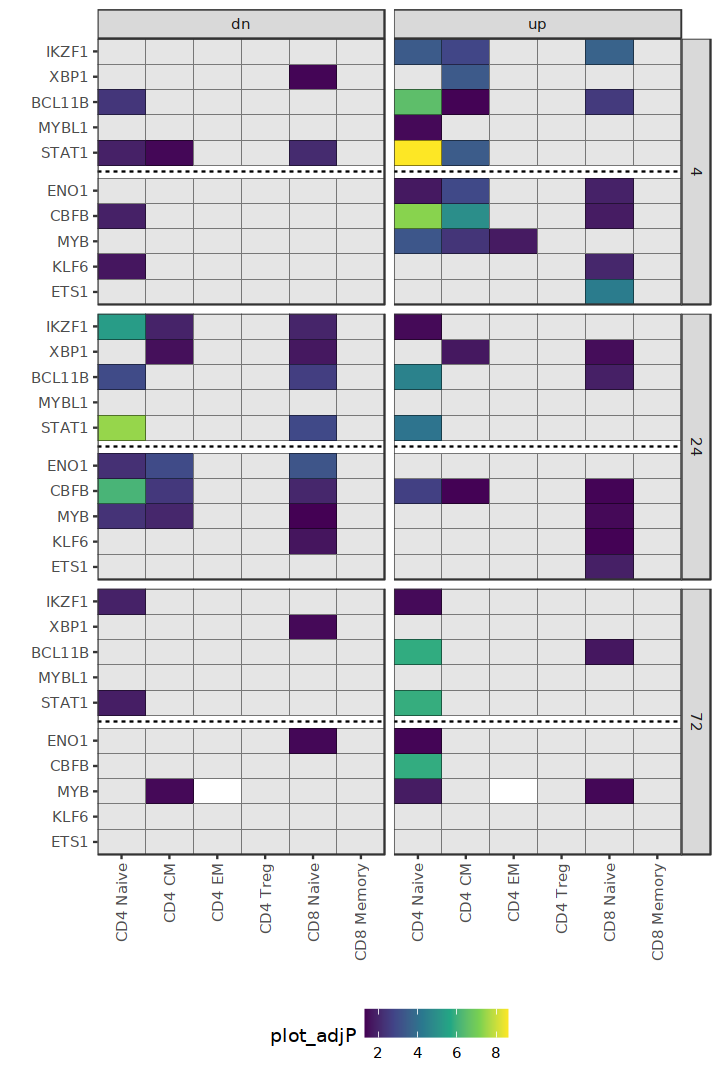

In [17]:
options(repr.plot.width = 6, repr.plot.height = 9)
enrich_plot <- ggplot() +
  geom_hline(data = data.frame(y = 0.25),
             aes(yintercept = y),
             linetype = "dashed") +
  geom_tile(
      data = plot_data,
      aes(x = cell_type_xpos,
          y = ypos,
          fill = plot_adjP
      ),
      color = "black"
  ) +
  scale_x_continuous(
      "",
      breaks = type_colors$cell_type_xpos,
      labels = type_colors$cell_type_label,
      limits = c(0.5, 6.5),
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = tf_pos$ypos,
      labels = tf_pos$tf_gene,
      limits = c(min(tf_pos$ypos) - 0.5, max(tf_pos$ypos) + 0.5),
      expand = c(0,0)
  ) +
  scale_fill_viridis_c(
      na.value = "gray90"
  ) +
  scale_size_area() +
  facet_grid(
      rows = vars(timepoint),
      cols = vars(direction)
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        panel.grid = element_blank(),
        legend.position = "bottom")
enrich_plot

In [18]:
tf_data <- res %>%
  filter(treatment == treat) %>%
  filter(tf_gene %in% tf_pos$tf_gene) %>%
  select(treatment, timepoint, aifi_cell_type, tf_gene, tf_logFC, tf_adjP) %>%
  unique() %>%
  left_join(type_colors) %>%
  left_join(tf_pos)
tf_sig <- tf_data %>%
  filter(tf_adjP < 0.01)

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(tf_gene)`


In [19]:
write.csv(
    tf_data,
    file.path(out_dir, paste0("lenalidomide_top_tf_deg_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

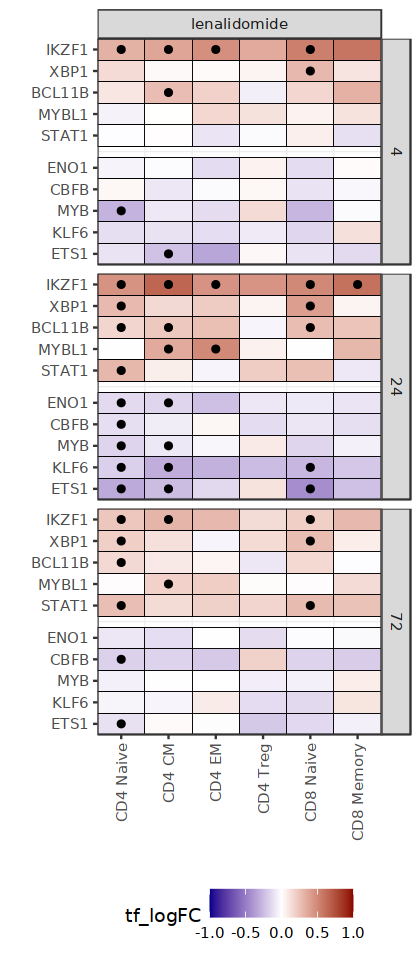

In [20]:
options(repr.plot.width = 3.5, repr.plot.height = 8)
tf_diff_plot <- ggplot() +
  geom_tile(
      data = tf_data,
      aes(x = cell_type_xpos,
          y = ypos,
          fill = tf_logFC
      ),
      color = "black",
      linewidth = 0.2
  ) +
  geom_point(
      data = tf_sig,
      aes(x = cell_type_xpos,
          y = ypos),
      color = "black"
  ) +
  scale_x_continuous(
      "",
      breaks = type_colors$cell_type_xpos,
      labels = type_colors$cell_type_label,
      limits = c(0.5, 6.5),
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = tf_pos$ypos,
      labels = tf_pos$tf_gene,
      limits = c(min(tf_pos$ypos) - 0.5, max(tf_pos$ypos) + 0.5),
      expand = c(0,0)
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      midpoint = 0,
      na.value = "gray80",
      limits = c(-1, 1)
  ) +
  facet_grid(
      col = vars(treatment),
      row = vars(timepoint),
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        panel.grid.major = element_blank(),
        legend.position = "bottom")

tf_diff_plot

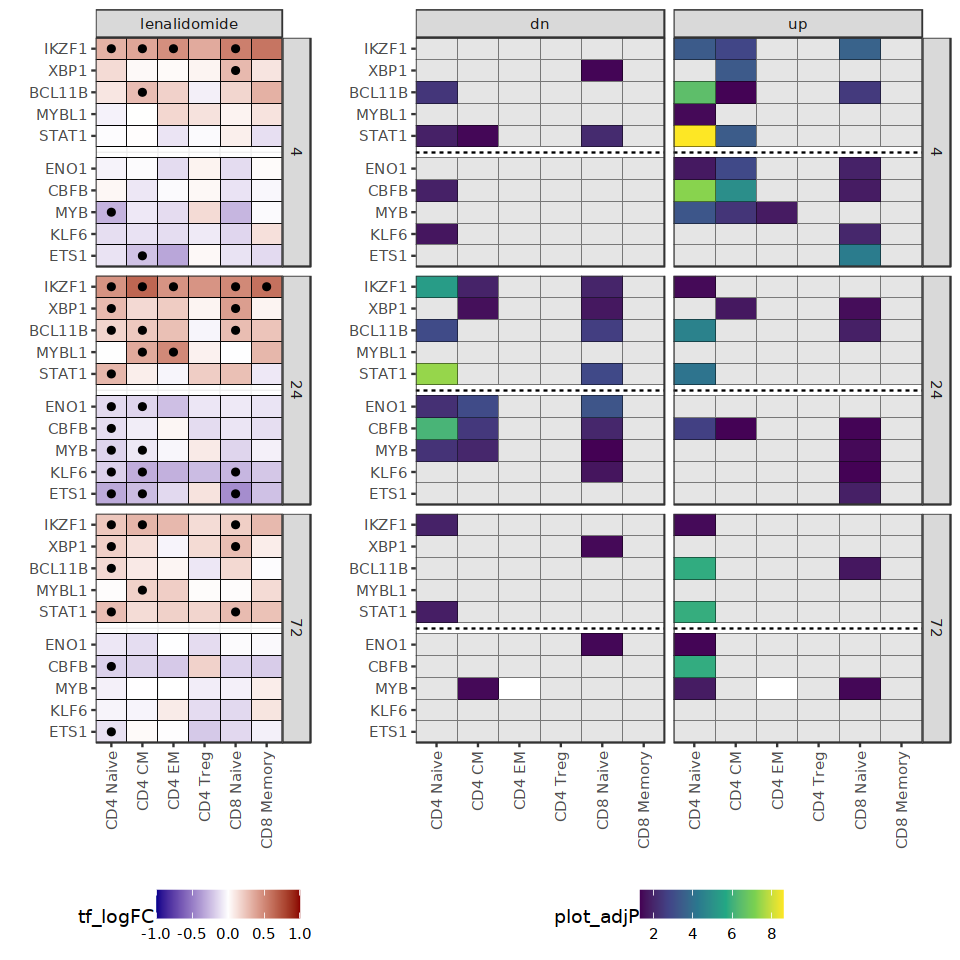

In [21]:
options(repr.plot.width = 8, repr.plot.height = 8)
combined_plots <- plot_grid(
    tf_diff_plot, enrich_plot,
    rel_widths = c(1,2),
    ncol = 2, nrow = 1,
    axis = "l",
    align = "v"
)
combined_plots

In [22]:
out_file <- file.path(out_dir, paste0("lenalidomide_top_tf_dem_heatmaps_", Sys.Date(), ".pdf"))
ggsave(
    out_file,
    combined_plots,
    width = 8, height = 8
)

## Bortezomib results

In [23]:
treat <- "bortezomib"

keep_tf <- res %>%
  select(treatment, timepoint, aifi_cell_type, tf_gene, tf_logFC, tf_adjP) %>%
  unique() %>%
  filter(treatment == treat,
         tf_adjP < tf_fdr_cutoff)

tt_res <- res %>%
  filter(treatment == treat,
         tf_gene %in% keep_tf$tf_gene)

Score TFs based on sum(target logFC) * fraction of DEGs? Or mean(target logFC)?

In [24]:
tf_pos <- keep_tf %>%
  group_by(tf_gene) %>%
  summarise(mean_logFC = mean(tf_logFC, na.rm = TRUE),
            sum_sig_logFC = sum(tf_logFC[tf_adjP < tf_fdr_cutoff], na.rm = TRUE)) %>%
  arrange(desc(sum_sig_logFC)) %>%
  mutate(ypos = n():1)

tf_pos <- rbind(head(tf_pos, top_n_tf),
                tail(tf_pos, top_n_tf)) %>%
  mutate(ypos = n():1 - top_n_tf - 0.5) %>%
  mutate(ypos = ifelse(1:n() <= top_n_tf, ypos + 0.5, ypos))

In [25]:
head(tf_pos)

tf_gene,mean_logFC,sum_sig_logFC,ypos
<chr>,<dbl>,<dbl>,<dbl>
BACH1,0.8062987,8.062987,5.0
ZEB1,0.7001444,7.001444,4.0
MAFG,0.4251007,4.676108,3.0
TFDP2,0.6431000,4.501700,2.0
E2F3,0.4636255,4.172629,1.0
IRF1,-0.6960362,-4.872253,-0.5


In [26]:
plot_data <- tt_res %>%
  filter(tf_gene %in% tf_pos$tf_gene) %>%
  left_join(type_colors) %>%
  left_join(tf_pos) %>%
  mutate(xmin = cell_type_xpos - frac_deg/2,
         xmax = cell_type_xpos + frac_deg/2,
         ) %>%
  mutate(plot_adjP = ifelse(
      adjP < enrichment_fdr_cutoff,
      -log10(adjP),
      NA
  ))
sig_plot_data <- plot_data %>%
  filter(adjP < enrichment_fdr_cutoff)

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(tf_gene)`


In [27]:
write.csv(
    plot_data,
    file.path(out_dir, paste0("bortezomib_top_tf_dem_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

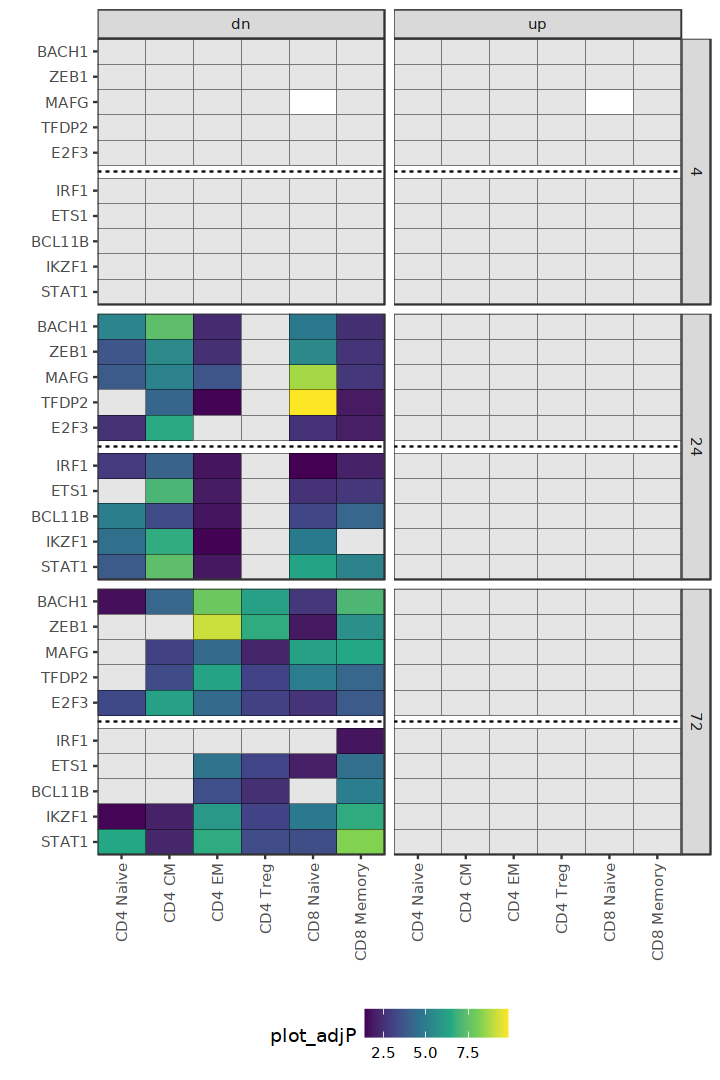

In [28]:
options(repr.plot.width = 6, repr.plot.height = 9)
enrich_plot <- ggplot() +
  geom_hline(data = data.frame(y = 0.25),
             aes(yintercept = y),
             linetype = "dashed") +
  geom_tile(
      data = plot_data,
      aes(x = cell_type_xpos,
          y = ypos,
          fill = plot_adjP
      ),
      color = "black"
  ) +
  scale_x_continuous(
      "",
      breaks = type_colors$cell_type_xpos,
      labels = type_colors$cell_type_label,
      limits = c(0.5, 6.5),
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = tf_pos$ypos,
      labels = tf_pos$tf_gene,
      limits = c(min(tf_pos$ypos) - 0.5, max(tf_pos$ypos) + 0.5),
      expand = c(0,0)
  ) +
  scale_fill_viridis_c(
      na.value = "gray90"
  ) +
  scale_size_area() +
  facet_grid(
      rows = vars(timepoint),
      cols = vars(direction)
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        panel.grid = element_blank(),
        legend.position = "bottom")
enrich_plot

In [29]:
tf_data <- res %>%
  filter(treatment == treat) %>%
  filter(tf_gene %in% tf_pos$tf_gene) %>%
  select(treatment, timepoint, aifi_cell_type, tf_gene, tf_logFC, tf_adjP) %>%
  unique() %>%
  left_join(type_colors) %>%
  left_join(tf_pos)
tf_sig <- tf_data %>%
  filter(tf_adjP < 0.01)

Joining with `by = join_by(aifi_cell_type)`
Joining with `by = join_by(tf_gene)`


In [30]:
write.csv(
    tf_data,
    file.path(out_dir, paste0("bortezomib_top_tf_deg_data_", Sys.Date(), ".csv")),
    quote = FALSE,
    row.names = FALSE
)

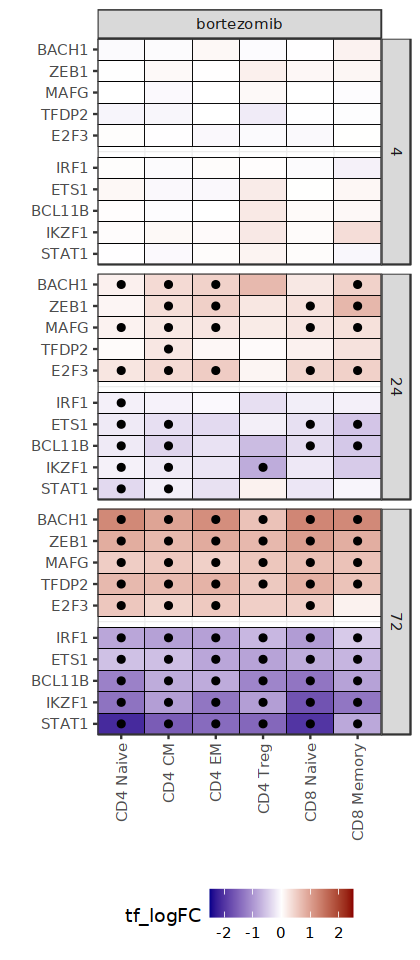

In [31]:
options(repr.plot.width = 3.5, repr.plot.height = 8)
tf_diff_plot <- ggplot() +
  geom_tile(
      data = tf_data,
      aes(x = cell_type_xpos,
          y = ypos,
          fill = tf_logFC
      ),
      color = "black",
      linewidth = 0.2
  ) +
  geom_point(
      data = tf_sig,
      aes(x = cell_type_xpos,
          y = ypos),
      color = "black"
  ) +
  scale_x_continuous(
      "",
      breaks = type_colors$cell_type_xpos,
      labels = type_colors$cell_type_label,
      limits = c(0.5, 6.5),
      expand = c(0,0)
  ) +
  scale_y_continuous(
      "",
      breaks = tf_pos$ypos,
      labels = tf_pos$tf_gene,
      limits = c(min(tf_pos$ypos) - 0.5, max(tf_pos$ypos) + 0.5),
      expand = c(0,0)
  ) +
  scale_fill_gradient2(
      low = "darkblue",
      mid = "white",
      high = "darkred",
      midpoint = 0,
      na.value = "gray80",
      limits = c(-2.5, 2.5)
  ) +
  facet_grid(
      col = vars(treatment),
      row = vars(timepoint),
  ) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
        panel.grid.major = element_blank(),
        legend.position = "bottom")

tf_diff_plot

In [32]:
library(cowplot)

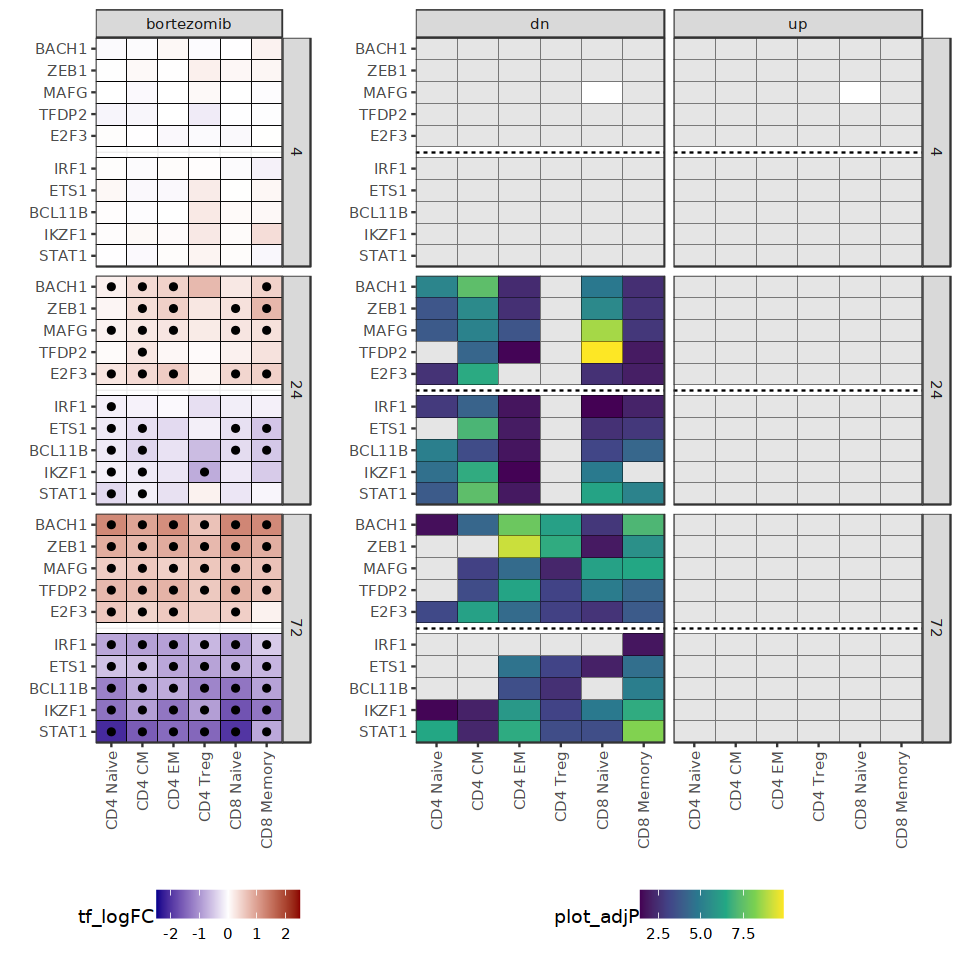

In [33]:
options(repr.plot.width = 8, repr.plot.height = 8)
combined_plots <- plot_grid(
    tf_diff_plot, enrich_plot,
    rel_widths = c(1,2),
    ncol = 2, nrow = 1,
    axis = "l",
    align = "v"
)
combined_plots

In [34]:
out_file <- file.path(out_dir, paste0("bortezomib_top_tf_dem_heatmaps_", Sys.Date(), ".pdf"))
ggsave(
    out_file,
    combined_plots,
    width = 8, height = 8
)

# Store results in HISE

Finally, we store the output file in our Collaboration Space for later retrieval and use. We need to provide the UUID for our Collaboration Space (aka `studySpaceId`), as well as a title for this step in our analysis process.

The hise function `uploadFiles()` also requires the FileIDs from the original fileset for reference.

In [35]:
study_space_uuid <- "40df6403-29f0-4b45-ab7d-f46d420c422e"
title <- paste("VRd TEA-seq Figure 5", Sys.Date())

In [36]:
out_files <- list.files(
    out_dir,
    full.names = TRUE
)
out_list <- as.list(out_files)

In [37]:
out_list

[[1]]
[1] "output/figure_5/bortezomib_top_tf_deg_data_2023-10-18.csv"

[[2]]
[1] "output/figure_5/bortezomib_top_tf_dem_data_2023-10-18.csv"

[[3]]
[1] "output/figure_5/bortezomib_top_tf_dem_heatmaps_2023-10-18.pdf"

[[4]]
[1] "output/figure_5/lenalidomide_top_tf_deg_data_2023-10-18.csv"

[[5]]
[1] "output/figure_5/lenalidomide_top_tf_dem_data_2023-10-18.csv"

[[6]]
[1] "output/figure_5/lenalidomide_top_tf_dem_heatmaps_2023-10-18.pdf"

In [39]:
in_list <- c(deg_uuid, tf_uuid)

In [40]:
uploadFiles(
    files = out_list,
    studySpaceId = study_space_uuid,
    title = title,
    inputFileIds = in_list,
    store = "project",
    doPrompt = FALSE
)

$files
$files[[1]]
[1] "output/figure_5/bortezomib_top_tf_deg_data_2023-10-18.csv"

$files[[2]]
[1] "output/figure_5/bortezomib_top_tf_dem_data_2023-10-18.csv"

$files[[3]]
[1] "output/figure_5/bortezomib_top_tf_dem_heatmaps_2023-10-18.pdf"

$files[[4]]
[1] "output/figure_5/lenalidomide_top_tf_deg_data_2023-10-18.csv"

$files[[5]]
[1] "output/figure_5/lenalidomide_top_tf_dem_data_2023-10-18.csv"

$files[[6]]
[1] "output/figure_5/lenalidomide_top_tf_dem_heatmaps_2023-10-18.pdf"


$traceId
[1] "df08c9cc-ca11-488c-820a-f8bcbe4ab32a"

In [41]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1 ggplot2_3.4.3 dplyr_1.1.3   purrr_1.0.2   hise_2.16.0  

loaded via a namespace (and not attached):
 [1] gtable_0.3.4      jsonlite_1.8.7    compiler_4.3.1    crayon_1.5.2     
 [5] tidyselect_1.2.0  IRdisplay_1.1     bitops_1.0-7      assertthat_0.2.1 
 [9] textshaping_0.3.6 systemfonts_1.0.4 